In [72]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Input
from tensorflow.keras.models import Sequential
import yfinance as yf

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [73]:
# Define the list of top 10 cryptocurrencies
# assets = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY', 'AGG', 'PSP', 'VNQ', 'SLV', 'GLD', 'USO', 'DJI']
assets = ['AAPL']

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2024-01-01'

data_filepath = './data'

# Fetch historical data for each cryptocurrency
for crypto_symbol in assets:
    # Fetch historical data using yfinance
    crypto_data = yf.download(crypto_symbol, start=start_date, end=end_date)
    
    # Save data to a CSV file
    file_name = os.path.join(data_filepath, f"{crypto_symbol}_data.csv")
    crypto_data.to_csv(file_name)

[*********************100%%**********************]  1 of 1 completed


In [74]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)


# Function to preprocess data
def preprocess_data(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test


In [75]:
SEQ_LEN = 100
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
scaler = MinMaxScaler()
BATCH_SIZE = 64

# Function to train a model
def train_model(X_train, y_train, X_test, y_test):
    

    input_shape = (WINDOW_SIZE, X_train.shape[-1])
    inputs = Input(shape=input_shape)
    model = keras.Sequential()
    model.add(inputs)
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=1, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1)
    return model, history


In [76]:
# Function to plot loss history
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_and_plot(model, X_test, y_test, scaler, currency, df):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    
    # Get the original dates from the dataframe
    dates = df['Date'].values[-len(y_test_inverse):]
    
    # Plotting
    plt.plot(dates, y_test_inverse, label="Actual Price", color='green')
    plt.plot(dates, y_hat_inverse, label=f"{currency} Price", color='red')
    plt.title(f"{currency} Price")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')

    # Slant the dates on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    
    plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - loss: 0.0912 - val_loss: 0.0187


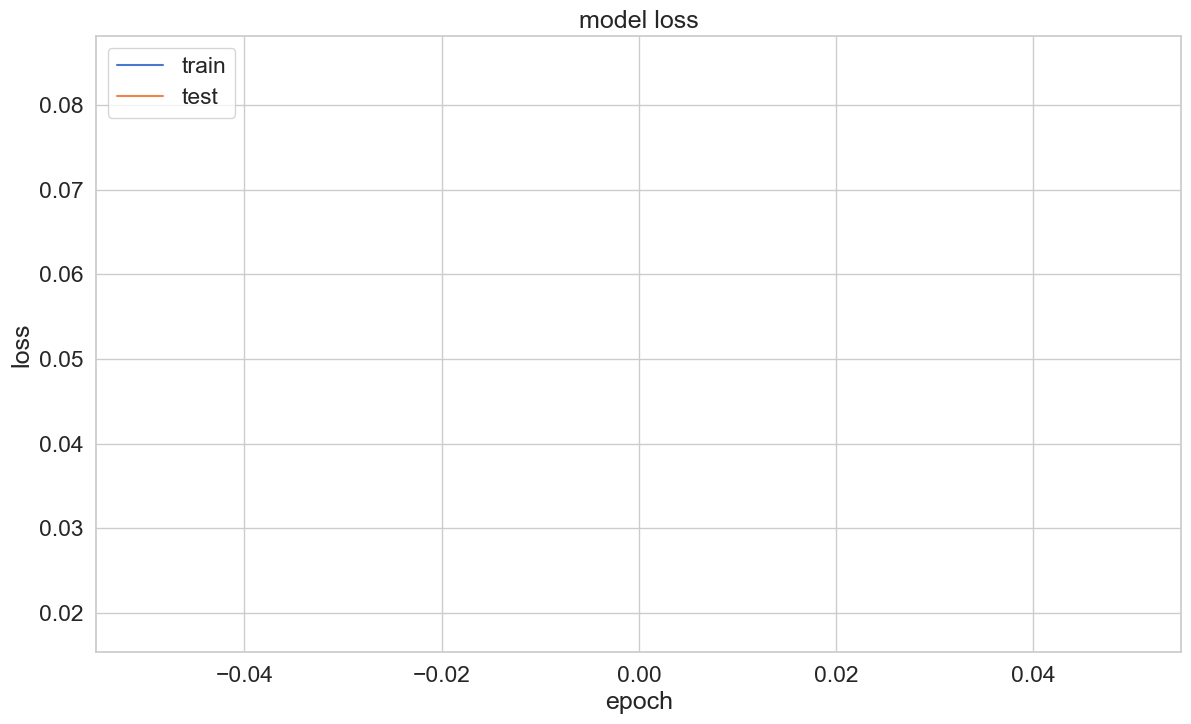

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


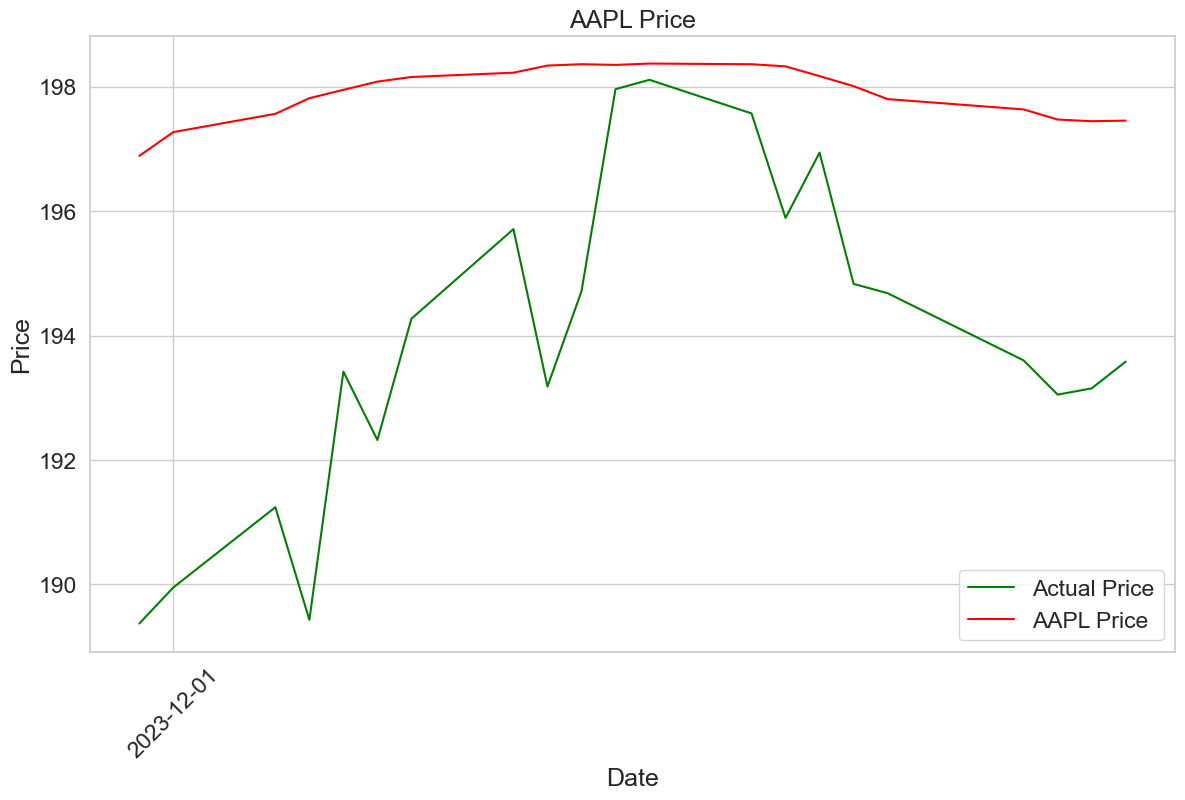

In [78]:
def main():

    models = {}
    histories = {}
    X_tests = {}
    y_tests = {}
    scalers = {}

    for asset in assets:
        csv_path = f'./data/{asset}_data.csv'
        df = pd.read_csv(csv_path, parse_dates=['Date'])
        close_price = df['Close'].values.reshape(-1, 1)
        scaled_close = scaler.fit_transform(close_price)
        X_train, y_train, X_test, y_test = preprocess_data(scaled_close, SEQ_LEN, train_split=0.95)
        model, history = train_model(X_train, y_train, X_test, y_test)
        plot_loss(history)
        predict_and_plot(model, X_test, y_test, scaler, asset, df)

        models[asset] = model
        histories[asset] = history
        X_tests[asset] = X_test
        y_tests[asset] = y_test
        scalers[asset] = scaler
    return models, histories, X_tests, y_tests, scalers

# Call the main function
models, histories, X_tests, y_tests, scalers = main()

In [79]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate evaluation metrics
def calculate_metrics(model, X_test, y_test, scaler):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    mse = mean_squared_error(y_test_inverse, y_hat_inverse)
    rmse = mean_squared_error(y_test_inverse, y_hat_inverse, squared=False)
    mae = mean_absolute_error(y_test_inverse, y_hat_inverse)
    return mse, rmse, mae

# Main function to compare models
def compare_models(models, histories, assets):
    evaluation_results = []
    for currency in assets:
        model = models[currency]
        history = histories[currency]
        X_test = X_tests[currency]
        y_test = y_tests[currency]
        scaler = scalers[currency]
        mse, rmse, mae = calculate_metrics(model, X_test, y_test, scaler)
        evaluation_results.append({'Currency': currency, 'MSE': mse, 'RMSE': rmse, 'MAE': mae})
    return pd.DataFrame(evaluation_results)


# Call the comparison function
evaluation_table = compare_models(models, histories, assets)
print(evaluation_table)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
  Currency        MSE      RMSE      MAE
0     AAPL  20.612982  4.540152  3.95614


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
